In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_curve
from sklearn.utils.class_weight import compute_sample_weight
from keras import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [2]:
VEC_SIZE = 300
SEED = 31415
np.random.seed(SEED)

In [3]:
def run_fasttext(name, words):
    with open('{}_query.txt'.format(name), 'w') as f:
        for word in words:
            f.write(word.lower() + '\n')

    !fastText/fasttext print-word-vectors cc.ru.300.bin < {name}_query.txt > {name}_answer.txt


def convert_to_vectors(name, words):
    data = np.zeros((len(words), VEC_SIZE))
    with open('{}_answer.txt'.format(name)) as f:
        for i, line in enumerate(f):
            data[i, :] = np.array(line.split()[-VEC_SIZE:], dtype=np.float64)
    return data

In [5]:
df = pd.read_csv('training_big.new.csv')
words = df['word'].values
labels = df['label'].values

In [6]:
indices = np.arange(len(words))
indices = np.random.RandomState(SEED).permutation(indices)
x_train = [words[i] for i in indices]
y_train = labels[indices]

In [7]:
if input('Run fasttext? ') == 'Y':
    run_fasttext('train', x_train)

Run fasttext?  Y


In [9]:
train_gened = convert_to_vectors('train', x_train)

In [10]:
model = Sequential()
model.add(Dense(30, activation='relu', input_shape=train_gened.shape[1:]))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.fit(train_gened, y_train, epochs=20, verbose=0,
          sample_weight=compute_sample_weight('balanced', y_train))

In [11]:
model.save('model')

In [12]:
df = pd.read_csv('testing.csv')
words = df['word'].values
labels = df['label'].values

In [13]:
run_fasttext('test', words)
test_data = convert_to_vectors('test', words)

In [14]:
predictions_train = model.predict_classes(train_gened)
print('f1:', f1_score(y_train, predictions_train))
print('accuracy:', accuracy_score(y_train, predictions_train))
confusion_matrix(y_train, predictions_train)

f1: 0.8489393065436134
accuracy: 0.9821984230083683


array([[123424,   2299],
       [    58,   6623]])

In [15]:
predictions_test = model.predict_classes(test_data)
print('f1:', f1_score(labels, predictions_test))
print('accuracy:', accuracy_score(labels, predictions_test))
confusion_matrix(labels, predictions_test)

f1: 0.8461538461538461
accuracy: 0.84


array([[40, 12],
       [ 4, 44]])

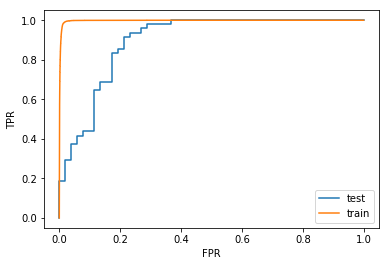

In [16]:
fpr, tpr, thresholds = roc_curve(labels, model.predict(test_data),
                                 sample_weight=compute_sample_weight('balanced', labels))
plt.plot(fpr, tpr, label='test')
fpr, tpr, thresholds = roc_curve(y_train, model.predict(train_gened),
                                 sample_weight=compute_sample_weight('balanced', y_train))
plt.plot(fpr, tpr, label='train')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [17]:
import re

lines = []
line_labels = []
with open('validation.txt') as f:
    for idx, line in enumerate(f):
        if idx % 2 == 0:
            lines.append(line[:-1])
        else:
            vulg = np.array(list(map(int, line[:-1])))
            line_labels.append(vulg)

words = []
labels = []
for sent, true in zip(lines, line_labels):
    for occ in re.finditer(r'\w+', sent):
        left, right = occ.span()
        words.append(sent[left:right])
        labels.append(1 if true[left:right].mean() >= 0.5 else 0)

In [18]:
run_fasttext('test', words)
test_data = convert_to_vectors('test', words)

In [65]:
predictions_test = (model.predict_proba(test_data) >= 0.99999).astype(np.int)  # model.predict_classes(test_data)

line_pred = []
occ_idx = 0
for idx, sent in enumerate(lines):
    cur_pred = np.zeros_like(line_labels[idx])
    for occ in re.finditer(r'\w+', sent):
        left, right = occ.span()
        if predictions_test[occ_idx] == 1:
            cur_pred[left:right] = 1
        occ_idx += 1
    line_pred.append(cur_pred)

print('Char-level F1:', f1_score(np.concatenate(line_labels), np.concatenate(line_pred)))
print('Token-level F1:', f1_score(labels, predictions_test))

Char-level F1: 0.3860179091595641
Token-level F1: 0.2787610619469027
